**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [1]:
#v20提交成绩得到了3.688， cv 成绩3.6519
#使用authorized_flag 进行特征分别处理,收到了奇效
#使用countVectorizer 对类别变量进行编码，内存存在压力

In [2]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# you need to obtain Wang's features from his notebook
df_train=pd.read_csv("train_wang_pur_date_4.csv")
df_test=pd.read_csv("test_wang_pur_date_4.csv")

In [5]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [6]:
len(df_train_columns)
len(exclude_features)

4

### Below part is based on : 
https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [74]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [94]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [76]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
223,new_hist_purchase_date_uptonow,1.245817e+06,307,3.587506
62,auth_hist_month_nunique,1.078922e+06,256,3.587506
84,auth_hist_purchase_date_max,1.957929e+06,214,3.587506
179,new_hist_purchase_amount_max,7.235416e+05,198,3.587506
190,new_hist_purchase_date_max,4.399713e+05,154,3.587506


In [151]:
actual_imp_df1=actual_imp_df.copy()

In [158]:
#actual_imp_df=feature_importance
actual_imp_df=actual_imp_df1.copy()

In [159]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
223,new_hist_purchase_date_uptonow,1.250744e+06,310,3.58773
62,auth_hist_month_nunique,1.070638e+06,249,3.58773
84,auth_hist_purchase_date_max,1.955274e+06,212,3.58773
179,new_hist_purchase_amount_max,7.213808e+05,195,3.58773
190,new_hist_purchase_date_max,4.455030e+05,158,3.58773


In [153]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,fold
102,auth_hist_purchase_date_max,2.058194e+06,1681.4,5.5
237,new_hist_purchase_date_uptonow,1.557911e+06,1127.5,5.5
235,new_hist_purchase_date_max,7.609263e+05,963.6,5.5
236,new_hist_purchase_date_min,6.159606e+05,726.9,5.5
93,auth_hist_month_nunique,1.150424e+06,648.2,5.5


In [55]:
import time


In [79]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  14.9 min)

In [80]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_rf1.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf1.csv')

In [90]:
#actual_imp_df=feature_importance

In [69]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [16]:
import matplotlib.gridspec as gridspec
import seaborn as sns

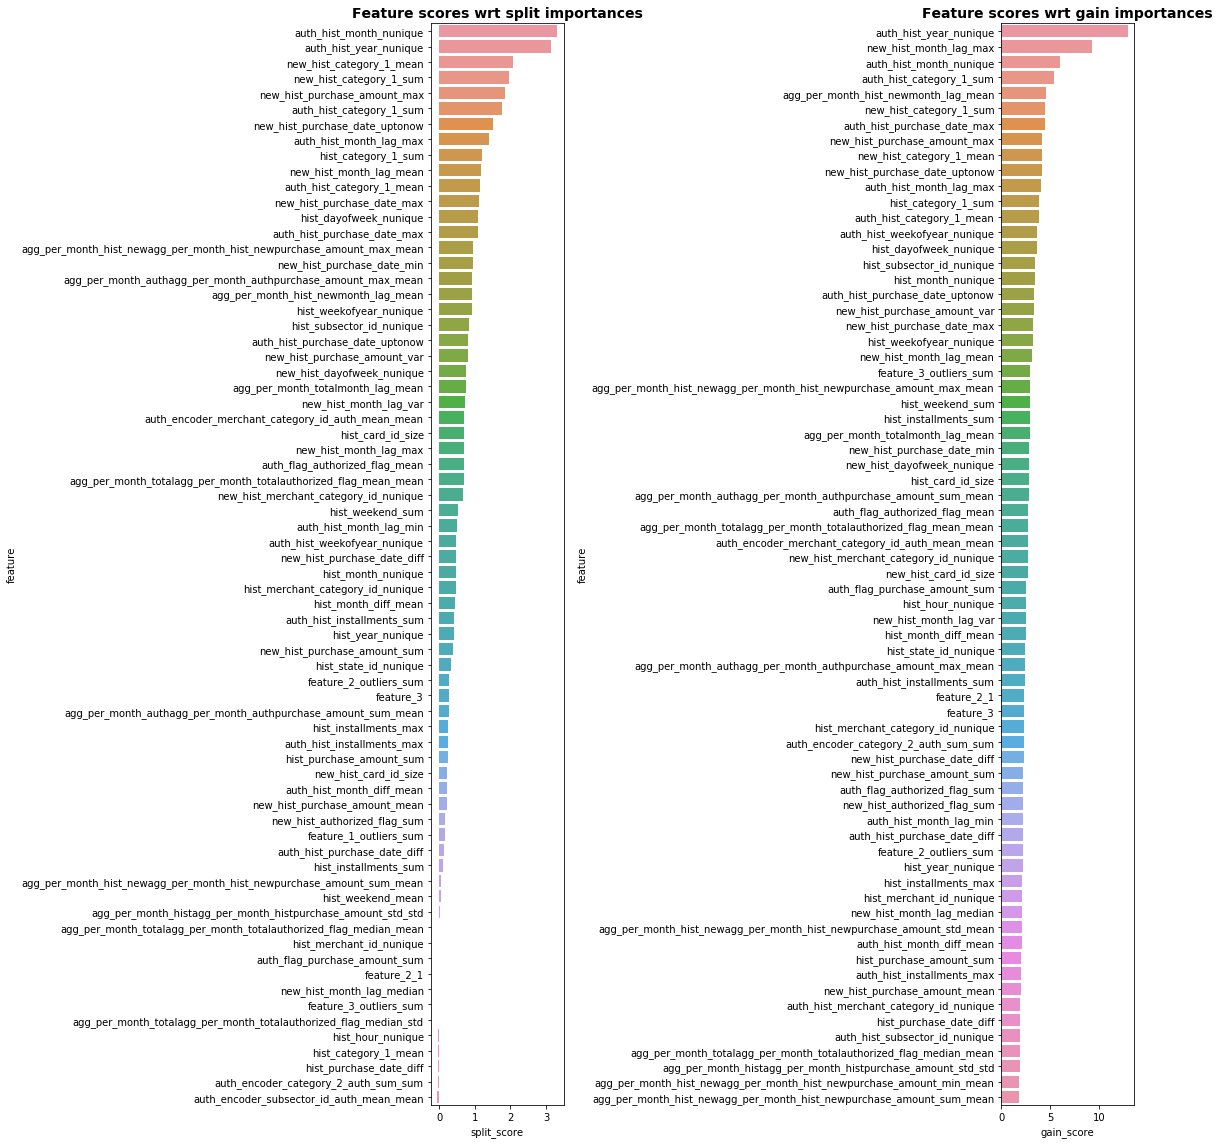

In [160]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

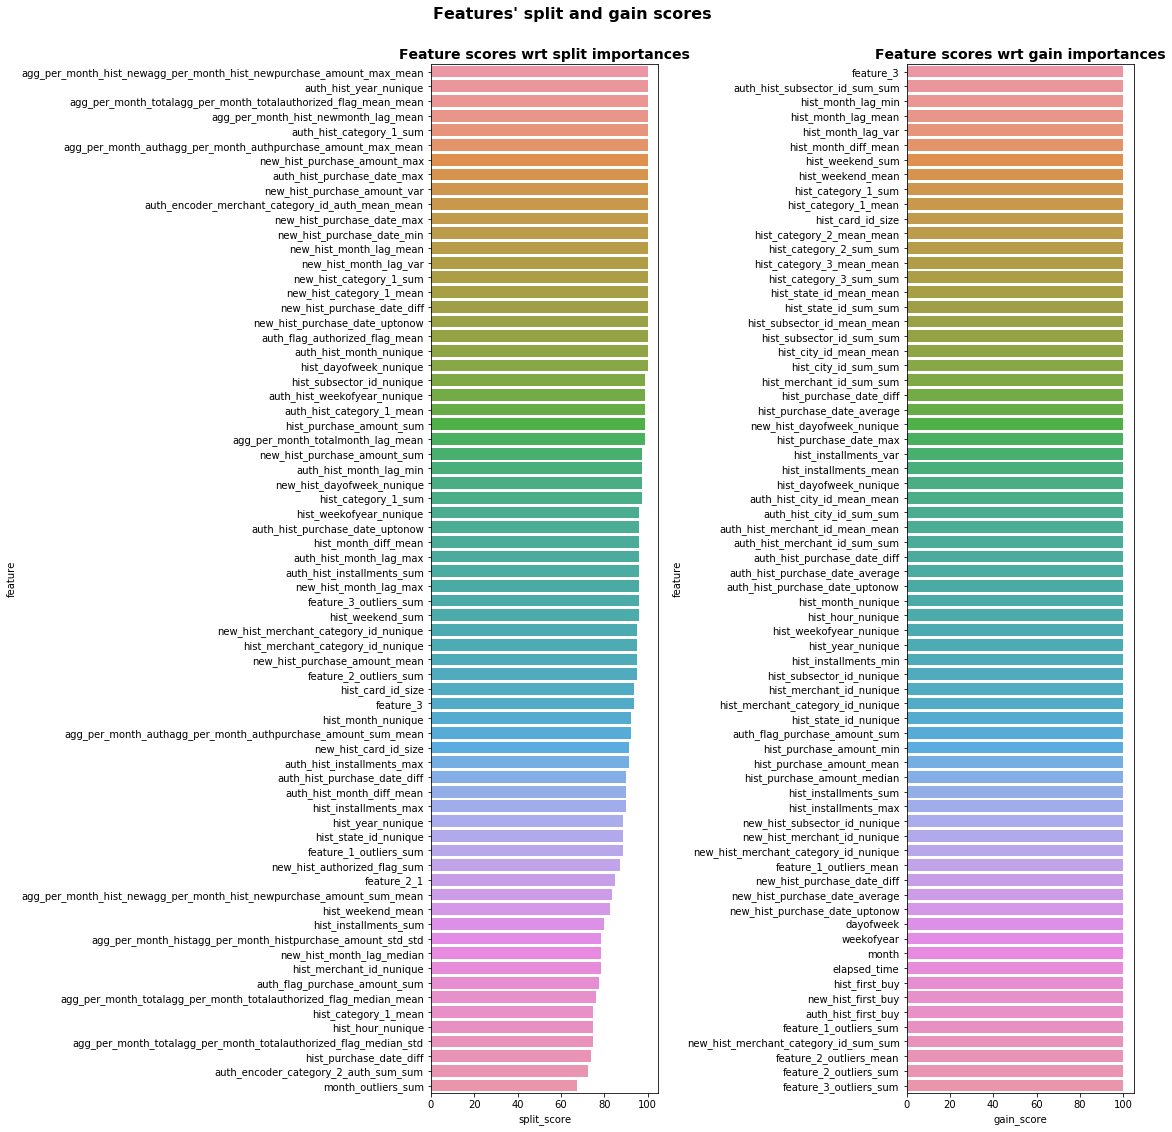

In [161]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [162]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

250
140
128
116
100
90
77
69
59
51
42
21


In [ ]:
250
246
246
246
246
246
245
245
245
240
236
224

250
131
120
110
103
91
77
70
63
49
42
21

In [66]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    
    dtrain = lgb.Dataset(df.loc[:,train_features], target, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=False,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last
    
    return hist['rmse-mean'][-1], hist['rmse-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

    
    

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results fo

In [157]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))
split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : '+ str(gain_results))
    gain_results_list.append(gain_results)

Results for threshold  10
	 SPLIT : 3.648666290911274
	 GAIN  : 3.6487187572524453
Results for threshold  70
	 SPLIT : 3.647716987447441
	 GAIN  : 3.6482274913103163
Results for threshold  90
	 SPLIT : 3.648054827327075
	 GAIN  : 3.6480988871469875
Results for threshold  95
	 SPLIT : 3.646546777848706
	 GAIN  : 3.646986825630301
Results for threshold  99
	 SPLIT : 3.647321559507341
	 GAIN  : 3.6487265649556284


In [120]:
split_results_list

[3.6479604740405716,
 3.642869515067212,
 3.643754463445602,
 3.6459211329232084,
 3.642984814383701,
 3.643275259005463,
 3.6426820017959587,
 3.6482091663559344,
 3.647831765247134,
 3.6471228986683544,
 3.6476997567832252,
 3.6657967712254194]

In [107]:
str(split_results)

'3.648584990565712'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [72]:
corr_scores_df.to_csv('correlation_feature_scores.csv')

In [67]:
split_results

(3.663243898568081, 0.04004850916480842)

In [58]:
len(split_feats)

250

In [59]:
df_train.columns.shape

(254,)

In [73]:
df_train_columns

['feature_3',
 'auth_flag_purchase_amount_sum',
 'auth_flag_authorized_flag_sum',
 'auth_flag_authorized_flag_mean',
 'auth_flag_authorized_flag_std',
 'auth_flag_card_id_size',
 'auth_encoder_category_2_auth_mean_mean',
 'auth_encoder_category_2_auth_sum_sum',
 'auth_encoder_category_3_auth_mean_mean',
 'auth_encoder_category_3_auth_sum_sum',
 'auth_encoder_state_id_auth_mean_mean',
 'auth_encoder_state_id_auth_sum_sum',
 'auth_encoder_subsector_id_auth_mean_mean',
 'auth_encoder_subsector_id_auth_sum_sum',
 'auth_encoder_merchant_category_id_auth_mean_mean',
 'auth_encoder_merchant_category_id_auth_sum_sum',
 'auth_encoder_city_id_auth_mean_mean',
 'auth_encoder_city_id_auth_sum_sum',
 'agg_per_month_totalmonth_lag_mean',
 'agg_per_month_totalmonth_lag_std',
 'agg_per_month_totalagg_per_month_totalauthorized_flag_sum_mean',
 'agg_per_month_totalagg_per_month_totalauthorized_flag_sum_std',
 'agg_per_month_totalagg_per_month_totalauthorized_flag_mean_mean',
 'agg_per_month_totalagg_per

In [74]:
# best slit feats let's check in our code
# split_feats = [_f for _f, _score, _ in correlation_scores if _score >= 10]

In [82]:
# corr_score_list=corr_scores_df.values.tolist()

In [163]:
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= 10]

In [164]:
len(split_feats)

140

In [165]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    trn_data = lgb.Dataset(df_train.iloc[trn_idx][split_feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][split_feats], label=target.iloc[val_idx])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][split_feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = split_feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[split_feats], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66887	valid_1's rmse: 3.71926
[200]	training's rmse: 3.58784	valid_1's rmse: 3.68279
[300]	training's rmse: 3.53566	valid_1's rmse: 3.66949
[400]	training's rmse: 3.49702	valid_1's rmse: 3.66288
[500]	training's rmse: 3.46549	valid_1's rmse: 3.65852
[600]	training's rmse: 3.44032	valid_1's rmse: 3.65658
[700]	training's rmse: 3.41714	valid_1's rmse: 3.65568
[800]	training's rmse: 3.39708	valid_1's rmse: 3.65538
[900]	training's rmse: 3.37839	valid_1's rmse: 3.65439
Early stopping, best iteration is:
[899]	training's rmse: 3.37852	valid_1's rmse: 3.65435
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66809	valid_1's rmse: 3.71017
[200]	training's rmse: 3.58812	valid_1's rmse: 3.67727
[300]	training's rmse: 3.5362	valid_1's rmse: 3.66453
[400]	training's rmse: 3.49716	valid_1's rmse: 3.6575
[500]	training's rmse: 3.46606	valid_1's rmse: 3.65399
[6

fold 9
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66655	valid_1's rmse: 3.72548
[200]	training's rmse: 3.58503	valid_1's rmse: 3.69542
[300]	training's rmse: 3.53289	valid_1's rmse: 3.68285
[400]	training's rmse: 3.49302	valid_1's rmse: 3.67638
[500]	training's rmse: 3.46083	valid_1's rmse: 3.67202
[600]	training's rmse: 3.43517	valid_1's rmse: 3.66942
[700]	training's rmse: 3.41226	valid_1's rmse: 3.66814
[800]	training's rmse: 3.39106	valid_1's rmse: 3.66797
[900]	training's rmse: 3.37166	valid_1's rmse: 3.66796
[1000]	training's rmse: 3.35432	valid_1's rmse: 3.6673
[1100]	training's rmse: 3.33756	valid_1's rmse: 3.66668
[1200]	training's rmse: 3.32217	valid_1's rmse: 3.66614
[1300]	training's rmse: 3.30618	valid_1's rmse: 3.66639
Early stopping, best iteration is:
[1229]	training's rmse: 3.31785	valid_1's rmse: 3.66597


3.642337850404535

results for without removing features(cpu): gives 3.687 in LB
3.6473470597331756
results with feature selection with treshould value is 10 (cpu)
3.6449471894576515

results with feature selection with treshould value is 60 but using gpu
3.642246405005863

results for without removing features(gpu):
3.648282457035372

results with feature selection with treshould value is 10 (gpu) give 3.685 in LB seems to be best
3.642337850404535

results with feature selection with treshould value is 60 but using gpu
3.642246405005863
 
results with feature selection with treshould value is 95 but using gpu
3.647622225792219

results with feature selection with treshould value is 99 but using gpu

3.665831848494995

['hist_month_diff_median' 'auth_hist_month_diff_median'
 'new_hist_month_lag_max' 'feature_1_3' 'feature_3_outliers_sum'
 'feature_1_3' 'new_hist_month_lag_max' 'auth_hist_month_diff_median'
 'new_hist_month_lag_max' 'feature_3_outliers_sum' 'feature_1_4'
 'feature_2_1' 'feature_3_outliers_sum' 'feature_2_1' 'feature_1_3'
 'feature_2_1' 'hist_month_diff_median' 'feature_3_outliers_sum'
 'hist_month_diff_median' 'auth_hist_month_diff_median'
 'new_hist_month_lag_max' 'feature_3_outliers_sum'
 'auth_hist_month_diff_median' 'auth_hist_month_diff_median' 'feature_2_1'
 'new_hist_month_lag_max' 'feature_1_3' 'new_hist_month_lag_max'
 'feature_2_1' 'auth_hist_month_diff_median']


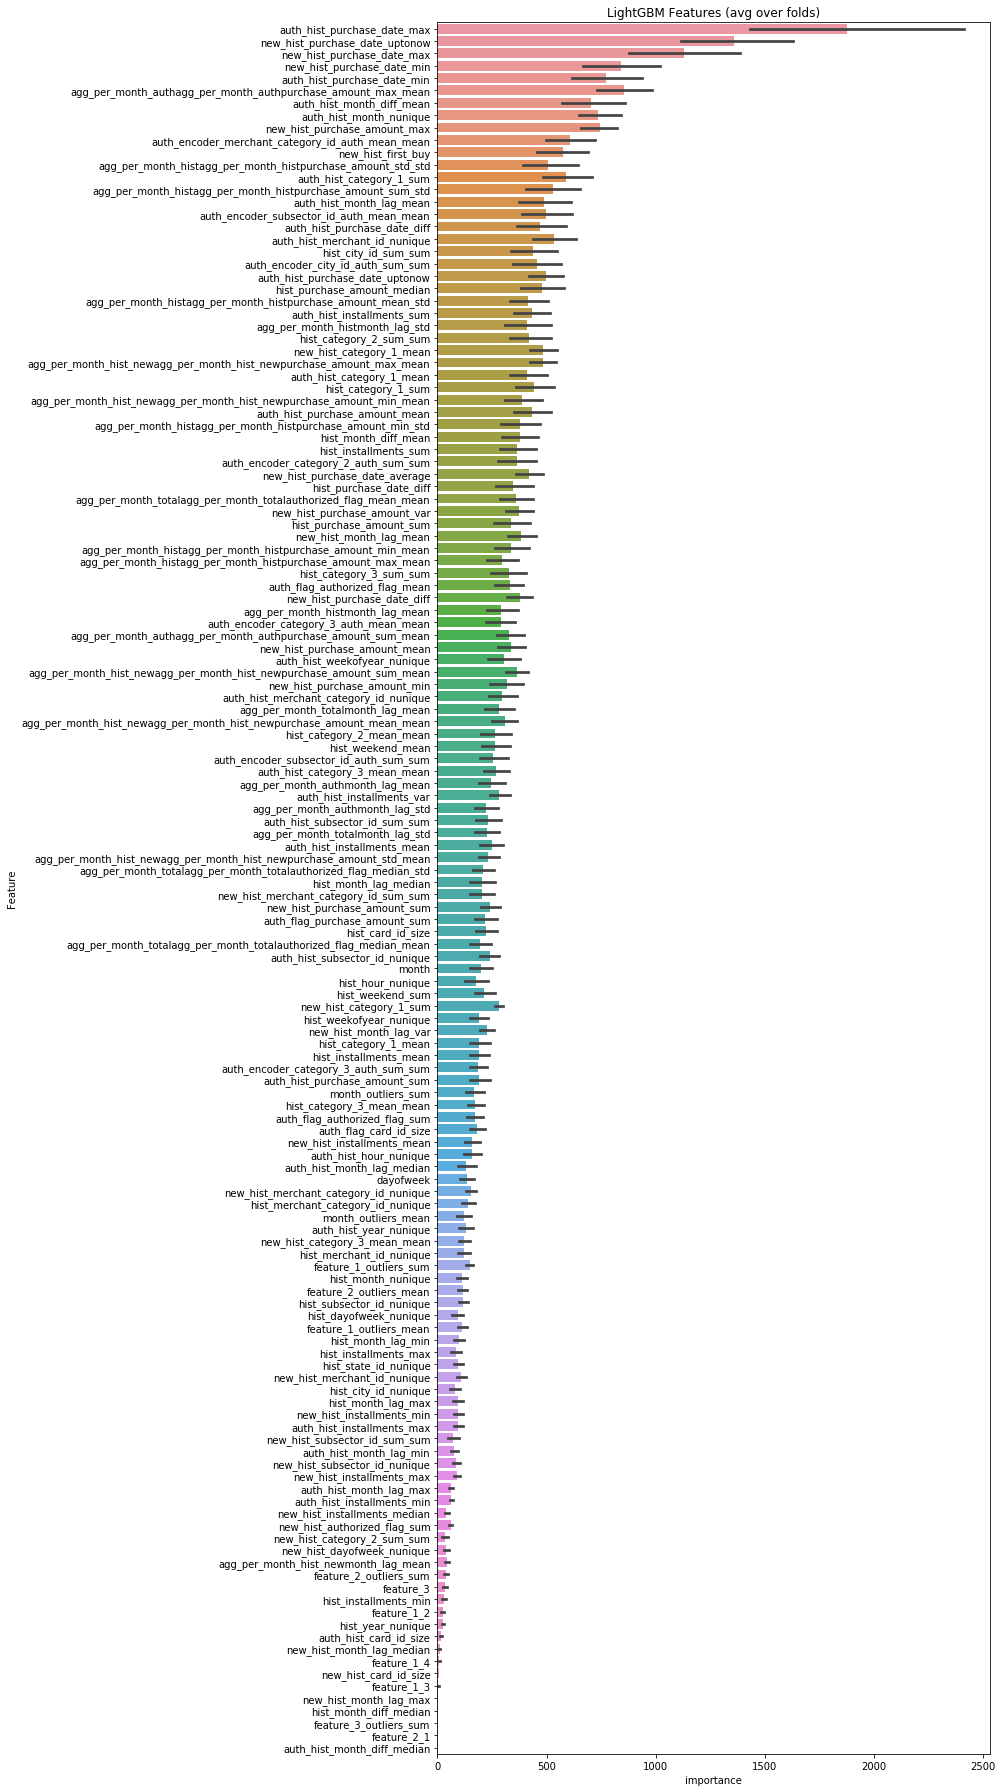

In [166]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
print(best_features.sort_values(by="importance",ascending=False)[-30:]['Feature'].values)
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')

In [167]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("wang_pur_date_4_with_outlier_feature_selection_gpu_10.csv", index=False)

### Now let's use stacking for further improvement

In [180]:
from sklearn.model_selection import KFold, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.linear_model import BayesianRidge


In [99]:

target=df_train.target

In [174]:
df_train_columns_all=df_train_columns.copy() # let's save we will need it later
df_train_columns=split_feats

In [177]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1,
         "device":"gpu"}

In [178]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73675	valid_1's rmse: 3.75547
[200]	training's rmse: 3.66978	valid_1's rmse: 3.7083
[300]	training's rmse: 3.62373	valid_1's rmse: 3.68361
[400]	training's rmse: 3.58949	valid_1's rmse: 3.67145
[500]	training's rmse: 3.56171	valid_1's rmse: 3.6636
[600]	training's rmse: 3.53844	valid_1's rmse: 3.65817
[700]	training's rmse: 3.51732	valid_1's rmse: 3.65369
[800]	training's rmse: 3.49938	valid_1's rmse: 3.65022
[900]	training's rmse: 3.48263	valid_1's rmse: 3.64758
[1000]	training's rmse: 3.4676	valid_1's rmse: 3.64586
[1100]	training's rmse: 3.45441	valid_1's rmse: 3.64337
[1200]	training's rmse: 3.4419	valid_1's rmse: 3.642
[1300]	training's rmse: 3.43014	valid_1's rmse: 3.64065
[1400]	training's rmse: 3.41873	valid_1's rmse: 3.64008
[1500]	training's rmse: 3.40822	valid_1's rmse: 3.63938
[1600]	training's rmse: 3.39813	valid_1's rmse: 3.63901
[1700]	training's rmse: 3.38849	valid_1's rmse:

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73603	valid_1's rmse: 3.74952
[200]	training's rmse: 3.66953	valid_1's rmse: 3.70229
[300]	training's rmse: 3.62395	valid_1's rmse: 3.67575
[400]	training's rmse: 3.59044	valid_1's rmse: 3.66008
[500]	training's rmse: 3.56249	valid_1's rmse: 3.65058
[600]	training's rmse: 3.53893	valid_1's rmse: 3.64405
[700]	training's rmse: 3.51801	valid_1's rmse: 3.63865
[800]	training's rmse: 3.50072	valid_1's rmse: 3.63516
[900]	training's rmse: 3.48438	valid_1's rmse: 3.63157
[1000]	training's rmse: 3.46989	valid_1's rmse: 3.62861
[1100]	training's rmse: 3.45635	valid_1's rmse: 3.62629
[1200]	training's rmse: 3.44365	valid_1's rmse: 3.62479
[1300]	training's rmse: 3.43219	valid_1's rmse: 3.62352
[1400]	training's rmse: 3.42118	valid_1's rmse: 3.62263
[1500]	training's rmse: 3.4111	valid_1's rmse: 3.6218
[1600]	training's rmse: 3.40101	valid_1's rmse: 3.62088
[1700]	training's rmse: 3.39178	valid_1's rmse: 3.62

[1800]	training's rmse: 3.37681	valid_1's rmse: 3.64719
[1900]	training's rmse: 3.3681	valid_1's rmse: 3.64657
[2000]	training's rmse: 3.35957	valid_1's rmse: 3.64605
[2100]	training's rmse: 3.35107	valid_1's rmse: 3.64562
[2200]	training's rmse: 3.3428	valid_1's rmse: 3.64533
[2300]	training's rmse: 3.33474	valid_1's rmse: 3.64485
[2400]	training's rmse: 3.32711	valid_1's rmse: 3.64476
[2500]	training's rmse: 3.31929	valid_1's rmse: 3.64442
[2600]	training's rmse: 3.31165	valid_1's rmse: 3.6444
[2700]	training's rmse: 3.30417	valid_1's rmse: 3.6442
[2800]	training's rmse: 3.29694	valid_1's rmse: 3.64385
[2900]	training's rmse: 3.28955	valid_1's rmse: 3.64345
[3000]	training's rmse: 3.28219	valid_1's rmse: 3.64305
[3100]	training's rmse: 3.27509	valid_1's rmse: 3.64277
[3200]	training's rmse: 3.26761	valid_1's rmse: 3.64247
[3300]	training's rmse: 3.26117	valid_1's rmse: 3.64235
[3400]	training's rmse: 3.25372	valid_1's rmse: 3.64244
Early stopping, best iteration is:
[3279]	training's

In [181]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590,
             "device":"gpu"}
#from sklearn.model_selection import RepeatedKFold
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(df_train))
predictions_lgb = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / (10 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))



fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67007	valid_1's rmse: 3.70689
[200]	training's rmse: 3.59066	valid_1's rmse: 3.66628
[300]	training's rmse: 3.53811	valid_1's rmse: 3.65131
[400]	training's rmse: 3.49936	valid_1's rmse: 3.64308
[500]	training's rmse: 3.46693	valid_1's rmse: 3.63655
[600]	training's rmse: 3.44081	valid_1's rmse: 3.63286
[700]	training's rmse: 3.41786	valid_1's rmse: 3.63082
[800]	training's rmse: 3.39651	valid_1's rmse: 3.62976
[900]	training's rmse: 3.37694	valid_1's rmse: 3.6284
[1000]	training's rmse: 3.35942	valid_1's rmse: 3.62807
[1100]	training's rmse: 3.34312	valid_1's rmse: 3.62769
[1200]	training's rmse: 3.32695	valid_1's rmse: 3.62768
Early stopping, best iteration is:
[1157]	training's rmse: 3.33433	valid_1's rmse: 3.62742
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66877	valid_1's rmse: 3.71377
[200]	training's rmse: 3.58858	valid_1's rmse: 3

[700]	training's rmse: 3.40995	valid_1's rmse: 3.66174
[800]	training's rmse: 3.38898	valid_1's rmse: 3.65972
[900]	training's rmse: 3.37122	valid_1's rmse: 3.65876
[1000]	training's rmse: 3.35372	valid_1's rmse: 3.65754
[1100]	training's rmse: 3.33684	valid_1's rmse: 3.65663
[1200]	training's rmse: 3.32046	valid_1's rmse: 3.65658
Early stopping, best iteration is:
[1117]	training's rmse: 3.33409	valid_1's rmse: 3.65641
fold n°10
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66998	valid_1's rmse: 3.70405
[200]	training's rmse: 3.58954	valid_1's rmse: 3.66314
[300]	training's rmse: 3.53732	valid_1's rmse: 3.64589
[400]	training's rmse: 3.4985	valid_1's rmse: 3.63681
[500]	training's rmse: 3.46655	valid_1's rmse: 3.63088
[600]	training's rmse: 3.43929	valid_1's rmse: 3.62771
[700]	training's rmse: 3.41654	valid_1's rmse: 3.6258
[800]	training's rmse: 3.39567	valid_1's rmse: 3.62579
[900]	training's rmse: 3.37737	valid_1's rmse: 3.62521
[1000]	tra

[900]	training's rmse: 3.37138	valid_1's rmse: 3.65197
[1000]	training's rmse: 3.35352	valid_1's rmse: 3.65113
[1100]	training's rmse: 3.33685	valid_1's rmse: 3.65046
Early stopping, best iteration is:
[1087]	training's rmse: 3.33878	valid_1's rmse: 3.65035
fold n°19
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66887	valid_1's rmse: 3.71322
[200]	training's rmse: 3.58709	valid_1's rmse: 3.68392
[300]	training's rmse: 3.53424	valid_1's rmse: 3.67174
[400]	training's rmse: 3.49551	valid_1's rmse: 3.66389
[500]	training's rmse: 3.46487	valid_1's rmse: 3.65943
[600]	training's rmse: 3.43805	valid_1's rmse: 3.65612
[700]	training's rmse: 3.41564	valid_1's rmse: 3.65411
[800]	training's rmse: 3.39463	valid_1's rmse: 3.65278
[900]	training's rmse: 3.37553	valid_1's rmse: 3.65208
[1000]	training's rmse: 3.35718	valid_1's rmse: 3.65195
Early stopping, best iteration is:
[936]	training's rmse: 3.3688	valid_1's rmse: 3.65166
CV score: 3.64499 


In [182]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


3.6429517055375173

Previous score: 3.646047433710033
Score with feature elimination: 3.6429517055375173

In [183]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('wang_stacking_with_outliers_feature_elimination.csv', index=False)

### Predictions of outliers

In [188]:
df_train_columns=df_train_columns_all.copy()
len(df_train_columns)

250

In [189]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['outliers'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['outliers'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1,
         "device" : "gpu"}

    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [190]:
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [191]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)


Done with   80 of   80 (Spent  15.4 min)

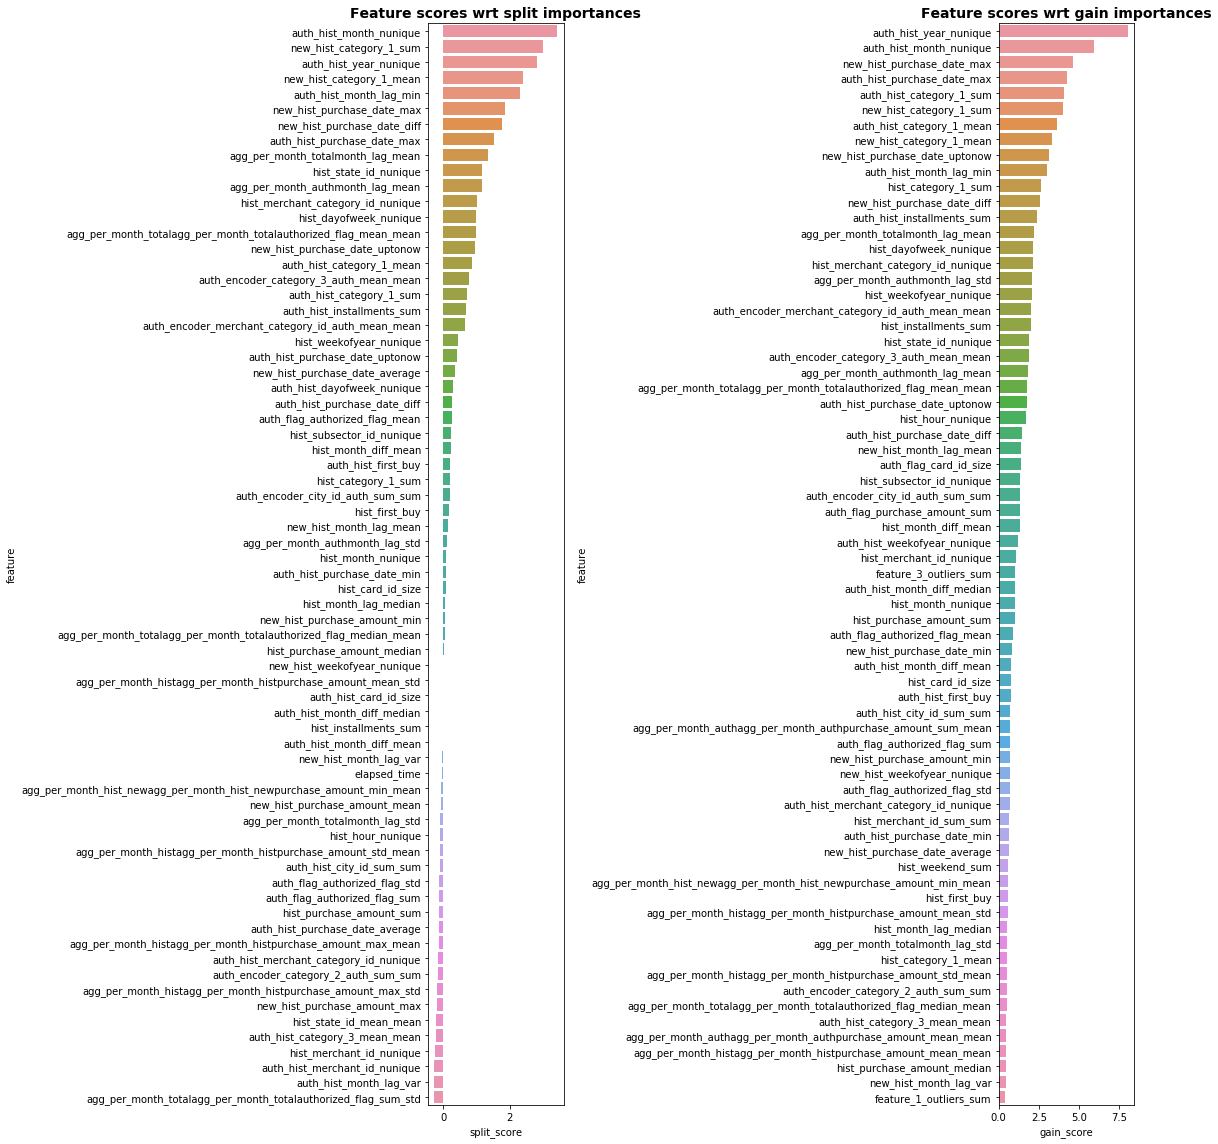

In [192]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

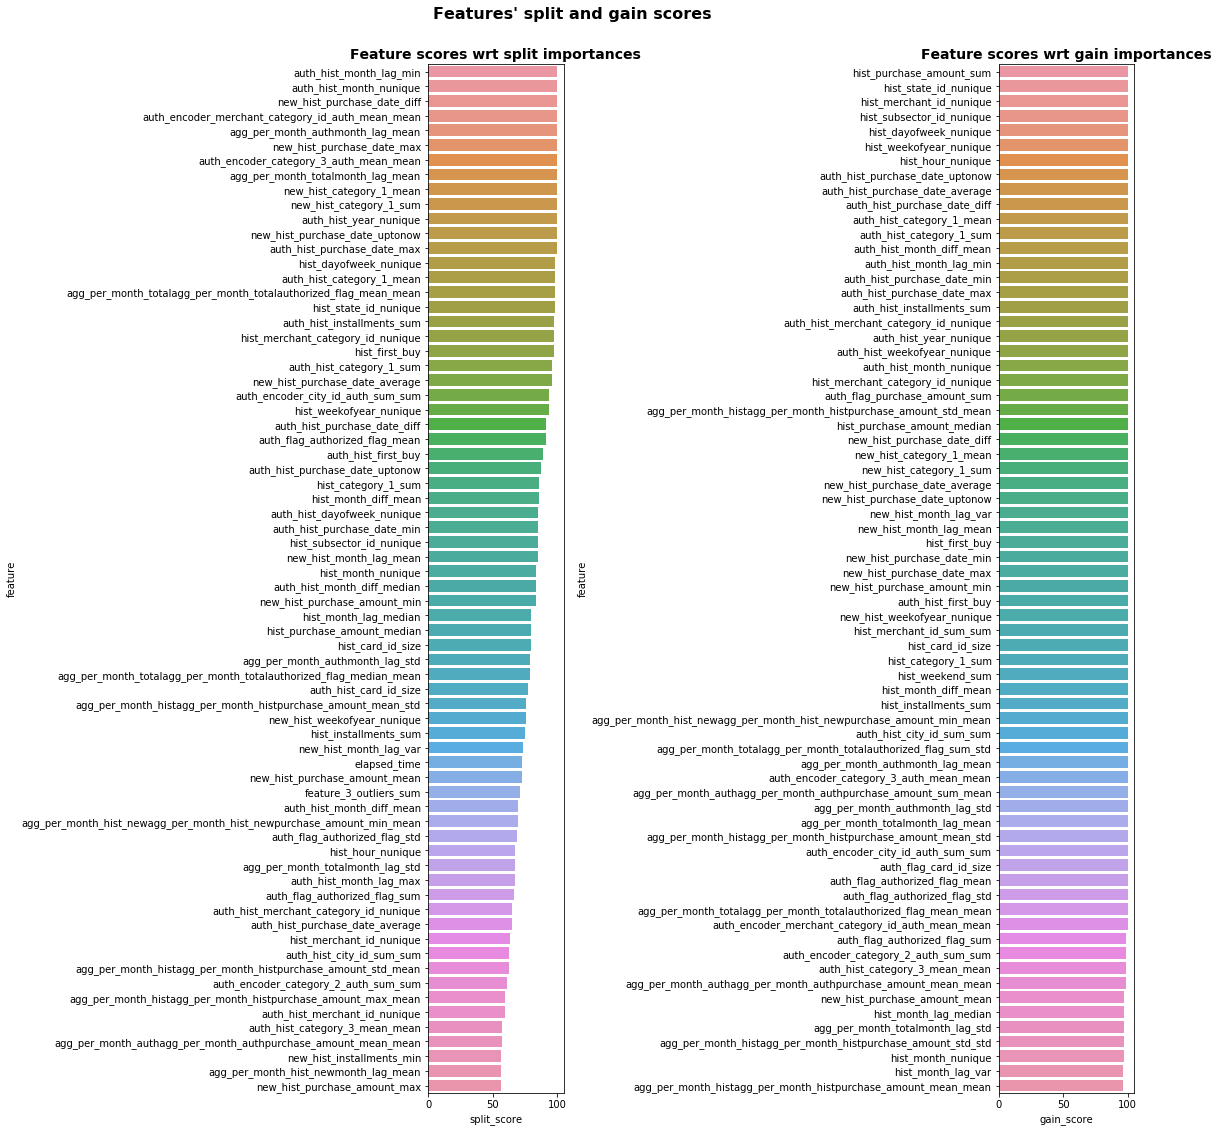

In [193]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [199]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1,
         "device" : "gpu"}

    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))
split_results_list=[]
gain_results_list=[]
for threshold in [ 50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['outliers'])
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['outliers'])
    print('\t GAIN  : '+ str(gain_results))
    gain_results_list.append(gain_results)

Results for threshold  50
	 SPLIT : 0.09915145935943692
	 GAIN  : 0.09915243736700094
Results for threshold  60


KeyboardInterrupt: 

Results for threshold   0
	 SPLIT : 0.09927516776088509
	 GAIN  : 0.0992807708180768
Results for threshold  10
	 SPLIT : 0.09912905643612276
	 GAIN  : 0.09920891477232445
Results for threshold  20
	 SPLIT : 0.09919306495804209
	 GAIN  : 0.09917566293025519
Results for threshold  30
	 SPLIT : 0.09914557131429592
	 GAIN  : 0.0991907565478424
Results for threshold  40
	 SPLIT : 0.09912911441937061
	 GAIN  : 0.09919486373550601
Results for threshold  50
	 SPLIT : 0.09915221028296584

In [195]:
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    print(len(split_feats))

250
142
117
98
85
75
65
52
40
26
22
13


In [198]:
len(df_train_columns_all)

250

In [200]:
target=df_train.outliers
threshold=10
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
df_train_columns=split_feats

In [202]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1,
         "device":"gpu"}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0464511	valid_1's binary_logloss: 0.049037
[200]	training's binary_logloss: 0.0421814	valid_1's binary_logloss: 0.0460905
[300]	training's binary_logloss: 0.0395172	valid_1's binary_logloss: 0.0447898
[400]	training's binary_logloss: 0.0375794	valid_1's binary_logloss: 0.0441253
[500]	training's binary_logloss: 0.0359851	valid_1's binary_logloss: 0.0437753
[600]	training's binary_logloss: 0.0345971	valid_1's binary_logloss: 0.0435106
[700]	training's binary_logloss: 0.0333945	valid_1's binary_logloss: 0.0434142
[800]	training's binary_logloss: 0.0323309	valid_1's binary_logloss: 0.0433481
[900]	training's binary_logloss: 0.0313917	valid_1's binary_logloss: 0.0432982
[1000]	training's binary_logloss: 0.0304929	valid_1's binary_logloss: 0.0432779
[1100]	training's binary_logloss: 0.0296469	valid_1's binary_logloss: 0.0432572
[1200]	training's binary_logloss: 0.0288655	valid_1's bina

[1500]	training's binary_logloss: 0.0268579	valid_1's binary_logloss: 0.0428177
[1600]	training's binary_logloss: 0.0262233	valid_1's binary_logloss: 0.0428062
[1700]	training's binary_logloss: 0.0256019	valid_1's binary_logloss: 0.0428178
Early stopping, best iteration is:
[1562]	training's binary_logloss: 0.0264547	valid_1's binary_logloss: 0.0427987
fold n°6
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0465846	valid_1's binary_logloss: 0.0489318
[200]	training's binary_logloss: 0.0422637	valid_1's binary_logloss: 0.0457546
[300]	training's binary_logloss: 0.039602	valid_1's binary_logloss: 0.0442888
[400]	training's binary_logloss: 0.0376334	valid_1's binary_logloss: 0.0434725
[500]	training's binary_logloss: 0.0360193	valid_1's binary_logloss: 0.0430092
[600]	training's binary_logloss: 0.0346753	valid_1's binary_logloss: 0.0427339
[700]	training's binary_logloss: 0.0334731	valid_1's binary_logloss: 0.0425932
[800]	training's bina

CV score before :0.09932 
CV score after feature elimination: 0.09916 

In [203]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'binary',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'binary_logloss',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590,
             "device":"gpu"}

folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(df_train))
predictions_lgb = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / (10 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))


fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0421198	valid_1's binary_logloss: 0.0460863
[200]	training's binary_logloss: 0.0374935	valid_1's binary_logloss: 0.0441688
[300]	training's binary_logloss: 0.0344946	valid_1's binary_logloss: 0.0436529
[400]	training's binary_logloss: 0.0322235	valid_1's binary_logloss: 0.0434528
[500]	training's binary_logloss: 0.0304139	valid_1's binary_logloss: 0.0434098
[600]	training's binary_logloss: 0.0288048	valid_1's binary_logloss: 0.0434209
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0301606	valid_1's binary_logloss: 0.0433993
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0420334	valid_1's binary_logloss: 0.0462822
[200]	training's binary_logloss: 0.0375228	valid_1's binary_logloss: 0.044285
[300]	training's binary_logloss: 0.0345786	valid_1's binary_logloss: 0.0436943
[400]	training's binary_logloss:

fold n°11
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0420811	valid_1's binary_logloss: 0.0463812
[200]	training's binary_logloss: 0.0374126	valid_1's binary_logloss: 0.0442618
[300]	training's binary_logloss: 0.0344661	valid_1's binary_logloss: 0.0436683
[400]	training's binary_logloss: 0.0322513	valid_1's binary_logloss: 0.043443
[500]	training's binary_logloss: 0.0304088	valid_1's binary_logloss: 0.0433181
[600]	training's binary_logloss: 0.0287887	valid_1's binary_logloss: 0.0432782
[700]	training's binary_logloss: 0.0273383	valid_1's binary_logloss: 0.0432399
[800]	training's binary_logloss: 0.0260369	valid_1's binary_logloss: 0.0432228
[900]	training's binary_logloss: 0.0248259	valid_1's binary_logloss: 0.0432381
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.0258459	valid_1's binary_logloss: 0.0432131
fold n°12
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_loglos

CV score before: 0.09937 

In [204]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


0.09911225586735214

Score before:0.09927839416004493

Prediction before: 0.09927839416004493
Prediction after feature elimination:0.09911225586735214 

In [205]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('wang_stacking_outliers_map_feature_elimination.csv', index=False)

### Now. let's do predictions without outliers


In [206]:
df_train1=df_train[df_train.outliers==0]
target=df_train1.target

In [209]:
df_train_original=df_train.copy()

In [210]:
df_train=df_train1

In [211]:
df_train.shape

(199710, 254)

In [227]:
df_train_columns=df_train_columns_all.copy()

In [228]:
len(df_train_columns)


250

In [229]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [230]:
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [231]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  15.3 min)

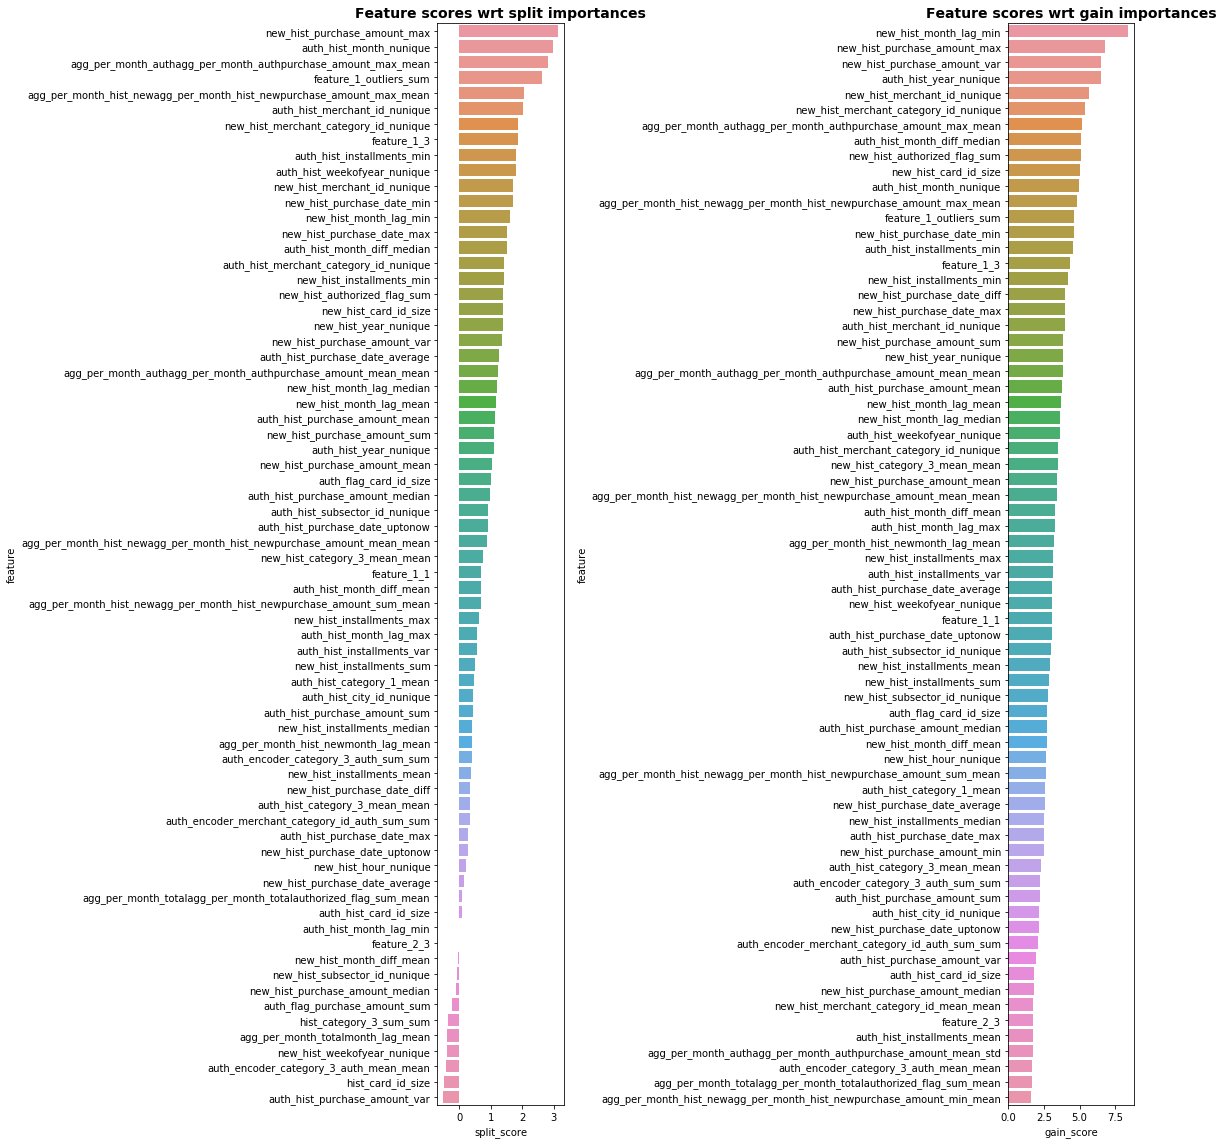

In [232]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

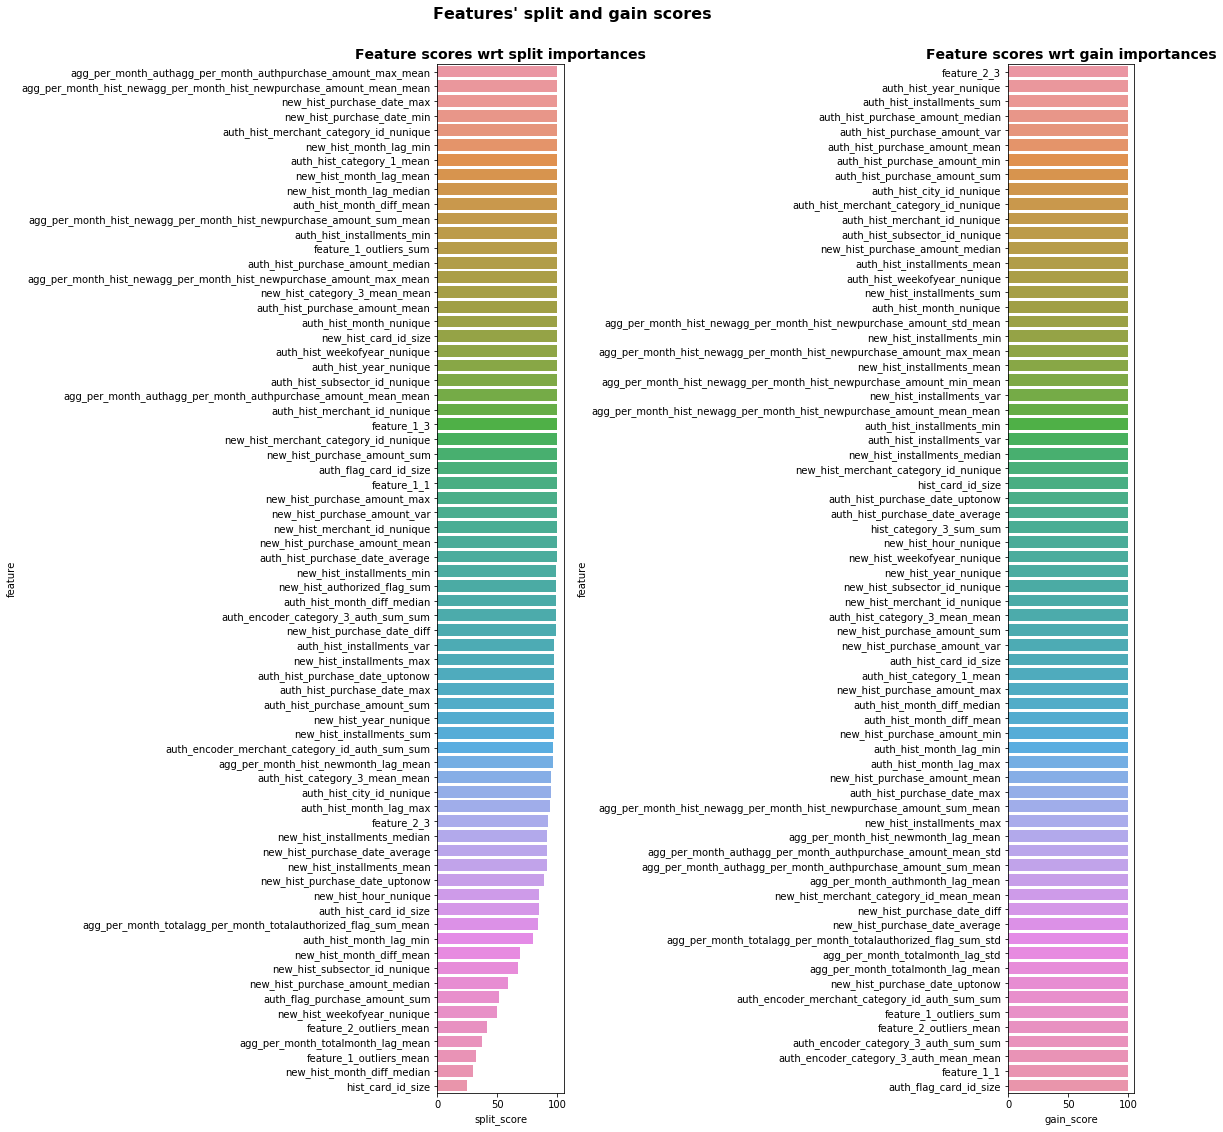

In [233]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [234]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))
split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : '+ str(gain_results))
    gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 1.553868165475607
	 GAIN  : 1.553956103575383
Results for threshold  10
	 SPLIT : 1.5527822444286754
	 GAIN  : 1.5525763719071648
Results for threshold  20
	 SPLIT : 1.5526625249344093
	 GAIN  : 1.5521732244439048
Results for threshold  30
	 SPLIT : 1.5527472521586307
	 GAIN  : 1.5520774095676926
Results for threshold  40
	 SPLIT : 1.5529283989597358
	 GAIN  : 1.5524383010731153
Results for threshold  50
	 SPLIT : 1.5527918017119862
	 GAIN  : 1.5527299028396961
Results for threshold  60
	 SPLIT : 1.5529472793329204
	 GAIN  : 1.5527378647137375
Results for threshold  70
	 SPLIT : 1.5528555647489013
	 GAIN  : 1.552578685854446
Results for threshold  80
	 SPLIT : 1.5528082759423159
	 GAIN  : 1.5523912604837364
Results for threshold  90
	 SPLIT : 1.5533692509096244
	 GAIN  : 1.5525703323169477
Results for threshold  95
	 SPLIT : 1.5538195311379026
	 GAIN  : 1.5524662517676644
Results for threshold  99
	 SPLIT : 1.5556460313560048
	 GAIN  : 1.552507202759

In [235]:
threshold_values=[ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]
if min(split_results_list)<=min(gain_results_list):
    min_score=np.argmin(split_results_list)
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold_values[min_score]]
else:
    min_score=np.argmin(gain_results_list)
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold_values[min_score]]
    split_feats = gain_feats

In [236]:
df_train_columns=split_feats

In [237]:
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))
                                                                                             

250
77
73
69
66
65
62
60
60
55
50
34


In [238]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1,
         "device":"gpu"}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
oof = np.zeros(len(df_train1))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train1.values, df_train1['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train1.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train1.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train1.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64179	valid_1's rmse: 1.64723
[200]	training's rmse: 1.60485	valid_1's rmse: 1.61374
[300]	training's rmse: 1.58491	valid_1's rmse: 1.59645
[400]	training's rmse: 1.57272	valid_1's rmse: 1.58622
[500]	training's rmse: 1.56408	valid_1's rmse: 1.57949
[600]	training's rmse: 1.55754	valid_1's rmse: 1.57482
[700]	training's rmse: 1.5522	valid_1's rmse: 1.57137
[800]	training's rmse: 1.54767	valid_1's rmse: 1.56864
[900]	training's rmse: 1.54367	valid_1's rmse: 1.56652
[1000]	training's rmse: 1.54012	valid_1's rmse: 1.56483
[1100]	training's rmse: 1.53692	valid_1's rmse: 1.56363
[1200]	training's rmse: 1.53391	valid_1's rmse: 1.56256
[1300]	training's rmse: 1.53117	valid_1's rmse: 1.56162
[1400]	training's rmse: 1.52861	valid_1's rmse: 1.5609
[1500]	training's rmse: 1.52616	valid_1's rmse: 1.56031
[1600]	training's rmse: 1.52386	valid_1's rmse: 1.55978
[1700]	training's rmse: 1.52171	valid_1's r

[4200]	training's rmse: 1.48033	valid_1's rmse: 1.54442
[4300]	training's rmse: 1.4788	valid_1's rmse: 1.54435
[4400]	training's rmse: 1.47734	valid_1's rmse: 1.54431
[4500]	training's rmse: 1.4758	valid_1's rmse: 1.54427
[4600]	training's rmse: 1.47431	valid_1's rmse: 1.54422
[4700]	training's rmse: 1.47288	valid_1's rmse: 1.54423
[4800]	training's rmse: 1.47134	valid_1's rmse: 1.54418
[4900]	training's rmse: 1.46988	valid_1's rmse: 1.5441
[5000]	training's rmse: 1.46844	valid_1's rmse: 1.54409
[5100]	training's rmse: 1.467	valid_1's rmse: 1.54401
[5200]	training's rmse: 1.46551	valid_1's rmse: 1.54399
[5300]	training's rmse: 1.4641	valid_1's rmse: 1.54403
Early stopping, best iteration is:
[5128]	training's rmse: 1.46657	valid_1's rmse: 1.54395
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64048	valid_1's rmse: 1.65844
[200]	training's rmse: 1.60366	valid_1's rmse: 1.6243
[300]	training's rmse: 1.5838	valid_1's rmse: 1.60656
[400]	tr

[1200]	training's rmse: 1.5364	valid_1's rmse: 1.54188
[1300]	training's rmse: 1.53364	valid_1's rmse: 1.54107
[1400]	training's rmse: 1.53106	valid_1's rmse: 1.54042
[1500]	training's rmse: 1.52859	valid_1's rmse: 1.53977
[1600]	training's rmse: 1.5263	valid_1's rmse: 1.53935
[1700]	training's rmse: 1.5241	valid_1's rmse: 1.53891
[1800]	training's rmse: 1.52197	valid_1's rmse: 1.53855
[1900]	training's rmse: 1.51987	valid_1's rmse: 1.53823
[2000]	training's rmse: 1.51798	valid_1's rmse: 1.53805
[2100]	training's rmse: 1.51609	valid_1's rmse: 1.53786
[2200]	training's rmse: 1.51424	valid_1's rmse: 1.5377
[2300]	training's rmse: 1.51237	valid_1's rmse: 1.53755
[2400]	training's rmse: 1.51058	valid_1's rmse: 1.53748
[2500]	training's rmse: 1.50878	valid_1's rmse: 1.53745
[2600]	training's rmse: 1.50705	valid_1's rmse: 1.53735
[2700]	training's rmse: 1.50535	valid_1's rmse: 1.53728
[2800]	training's rmse: 1.50366	valid_1's rmse: 1.53724
[2900]	training's rmse: 1.50201	valid_1's rmse: 1.53

[1600]	training's rmse: 1.52514	valid_1's rmse: 1.5474
[1700]	training's rmse: 1.5229	valid_1's rmse: 1.54694
[1800]	training's rmse: 1.52084	valid_1's rmse: 1.54659
[1900]	training's rmse: 1.51883	valid_1's rmse: 1.54627
[2000]	training's rmse: 1.51682	valid_1's rmse: 1.54612
[2100]	training's rmse: 1.51491	valid_1's rmse: 1.54595
[2200]	training's rmse: 1.51299	valid_1's rmse: 1.54583
[2300]	training's rmse: 1.51119	valid_1's rmse: 1.54567
[2400]	training's rmse: 1.50936	valid_1's rmse: 1.54556
[2500]	training's rmse: 1.50758	valid_1's rmse: 1.54549
[2600]	training's rmse: 1.50579	valid_1's rmse: 1.54534
[2700]	training's rmse: 1.50414	valid_1's rmse: 1.54525
[2800]	training's rmse: 1.50244	valid_1's rmse: 1.5452
[2900]	training's rmse: 1.50075	valid_1's rmse: 1.54508
[3000]	training's rmse: 1.49911	valid_1's rmse: 1.54507
[3100]	training's rmse: 1.49751	valid_1's rmse: 1.54496
[3200]	training's rmse: 1.49587	valid_1's rmse: 1.54495
[3300]	training's rmse: 1.49425	valid_1's rmse: 1.5

Previous CV score: 1.55323 
After feature elimination CV score: 1.55178 

In [239]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590,
             "device":"gpu"}

folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(df_train1))
predictions_lgb = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train1,df_train1['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train1.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train1.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(df_train1.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / (10 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))


fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60449	valid_1's rmse: 1.6159
[200]	training's rmse: 1.57242	valid_1's rmse: 1.58852
[300]	training's rmse: 1.55736	valid_1's rmse: 1.57719
[400]	training's rmse: 1.54751	valid_1's rmse: 1.57102
[500]	training's rmse: 1.53994	valid_1's rmse: 1.56723
[600]	training's rmse: 1.53385	valid_1's rmse: 1.56481
[700]	training's rmse: 1.52857	valid_1's rmse: 1.56314
[800]	training's rmse: 1.52392	valid_1's rmse: 1.56186
[900]	training's rmse: 1.51967	valid_1's rmse: 1.56089
[1000]	training's rmse: 1.5158	valid_1's rmse: 1.56037
[1100]	training's rmse: 1.5121	valid_1's rmse: 1.56002
[1200]	training's rmse: 1.50855	valid_1's rmse: 1.55972
[1300]	training's rmse: 1.50513	valid_1's rmse: 1.55942
[1400]	training's rmse: 1.50172	valid_1's rmse: 1.55919
[1500]	training's rmse: 1.4984	valid_1's rmse: 1.55896
[1600]	training's rmse: 1.49512	valid_1's rmse: 1.55872
[1700]	training's rmse: 1.49184	valid_1's rms

[500]	training's rmse: 1.53896	valid_1's rmse: 1.57296
[600]	training's rmse: 1.53274	valid_1's rmse: 1.57112
[700]	training's rmse: 1.52734	valid_1's rmse: 1.56971
[800]	training's rmse: 1.52266	valid_1's rmse: 1.56891
[900]	training's rmse: 1.51837	valid_1's rmse: 1.56822
[1000]	training's rmse: 1.5144	valid_1's rmse: 1.56787
[1100]	training's rmse: 1.51065	valid_1's rmse: 1.56748
[1200]	training's rmse: 1.50701	valid_1's rmse: 1.56724
[1300]	training's rmse: 1.50339	valid_1's rmse: 1.56711
[1400]	training's rmse: 1.49997	valid_1's rmse: 1.56707
[1500]	training's rmse: 1.4966	valid_1's rmse: 1.56699
[1600]	training's rmse: 1.49342	valid_1's rmse: 1.5668
[1700]	training's rmse: 1.49031	valid_1's rmse: 1.56669
[1800]	training's rmse: 1.48718	valid_1's rmse: 1.56661
[1900]	training's rmse: 1.48406	valid_1's rmse: 1.56669
Early stopping, best iteration is:
[1815]	training's rmse: 1.48672	valid_1's rmse: 1.5666
fold n°7
Training until validation scores don't improve for 100 rounds.
[100]	

[2800]	training's rmse: 1.459	valid_1's rmse: 1.55274
[2900]	training's rmse: 1.4563	valid_1's rmse: 1.55274
[3000]	training's rmse: 1.45352	valid_1's rmse: 1.55278
Early stopping, best iteration is:
[2921]	training's rmse: 1.45568	valid_1's rmse: 1.55269
fold n°12
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.60591	valid_1's rmse: 1.60428
[200]	training's rmse: 1.57382	valid_1's rmse: 1.57693
[300]	training's rmse: 1.55859	valid_1's rmse: 1.56592
[400]	training's rmse: 1.54869	valid_1's rmse: 1.55995
[500]	training's rmse: 1.54104	valid_1's rmse: 1.55639
[600]	training's rmse: 1.53475	valid_1's rmse: 1.55424
[700]	training's rmse: 1.52932	valid_1's rmse: 1.55277
[800]	training's rmse: 1.52451	valid_1's rmse: 1.55193
[900]	training's rmse: 1.52011	valid_1's rmse: 1.5514
[1000]	training's rmse: 1.51595	valid_1's rmse: 1.55117
[1100]	training's rmse: 1.51212	valid_1's rmse: 1.55082
[1200]	training's rmse: 1.50847	valid_1's rmse: 1.55059
[1300]	tr

[600]	training's rmse: 1.53248	valid_1's rmse: 1.57724
[700]	training's rmse: 1.52718	valid_1's rmse: 1.57556
[800]	training's rmse: 1.52247	valid_1's rmse: 1.57429
[900]	training's rmse: 1.51828	valid_1's rmse: 1.57354
[1000]	training's rmse: 1.51428	valid_1's rmse: 1.57283
[1100]	training's rmse: 1.51053	valid_1's rmse: 1.5724
[1200]	training's rmse: 1.50693	valid_1's rmse: 1.57223
[1300]	training's rmse: 1.50338	valid_1's rmse: 1.57191
[1400]	training's rmse: 1.49996	valid_1's rmse: 1.57169
[1500]	training's rmse: 1.49663	valid_1's rmse: 1.57168
[1600]	training's rmse: 1.49337	valid_1's rmse: 1.57147
[1700]	training's rmse: 1.49032	valid_1's rmse: 1.57132
[1800]	training's rmse: 1.48722	valid_1's rmse: 1.57122
[1900]	training's rmse: 1.48412	valid_1's rmse: 1.57109
[2000]	training's rmse: 1.48097	valid_1's rmse: 1.57096
[2100]	training's rmse: 1.47788	valid_1's rmse: 1.57093
Early stopping, best iteration is:
[2059]	training's rmse: 1.47912	valid_1's rmse: 1.57088
fold n°18
Training

Previous CV score: 1.55377 
After feature elimination CV score: 1.55187

In [240]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


1.5513494854463974

In [241]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('wang_stacking_without_outliers_feature_elimination.csv', index=False)

In [349]:
map1=pd.read_csv('wang_stacking_outliers_map_feature_elimination.csv',squeeze=True)
map1.set_index('card_id',inplace=True)
map2=map1.sort_values('target',ascending=False).head(18000)

In [350]:
model_with_outlier=pd.read_csv("wang_stacking_with_outliers_feature_elimination.csv")
model_without_outlier=pd.read_csv("wang_stacking_without_outliers_feature_elimination.csv")
model_with_outlier.set_index('card_id',inplace=True)
model_without_outlier.set_index('card_id',inplace=True)
# LB score 3.678

In [ ]:
model_with_mixed=model_without_outlier.copy()
model_with_mixed.loc[map2.index]=model_with_outlier.loc[map2.index]
model_with_mixed.reset_index(inplace=True)
model_with_mixed.to_csv("wang_stacking_mixed_outliers_pur_feature_elimination_18000.csv",index=False)

In [351]:
# this part is taken from Adams outliers prediction in my jupiter notebook
outliers=pd.read_csv('outliers_pred')
# this part is taken from send by Adams outliers prediction 
outliers_sent=pd.read_csv('outlier_prob.txt',header=None)

In [352]:
numeric_idx=outliers_sent.sort_values(0,ascending=False).head(10).index

In [353]:
card_id_outliers=outliers.loc[numeric_idx].card_id.values

In [354]:
outliers.set_index('card_id',inplace=True)
map3=outliers.sort_values('target',ascending=False).head(10)

In [355]:
map2.shape

(18000, 1)

In [357]:
model_with_mixed=model_without_outlier.copy()
model_with_mixed.loc[map2.index]=model_with_outlier.loc[map2.index]
model_with_mixed.loc[card_id_outliers]=-33.21928095
model_with_mixed.reset_index(inplace=True)
model_with_mixed.to_csv("manual_adam_outlier_sent_test_with_adam.csv",index=False)
# LB score 3.674

### Now let's used Adams model to predict outliers but we will use Wang's features

In [436]:
df_train_original.shape

(201917, 254)

In [437]:
len(df_train_columns)

105

In [438]:
len(df_train_columns_all)

250

In [376]:
def outlier(out_submit):
    #target = np.loadtxt(f'{prefix}.target.txt')
    
    #target_outlier = (target < -33).astype(int)
    target_outlier = df_train_original['outliers']

    train = df_train_original
    test = df_test
    features = df_train_columns_all
#     categorical_feats = [c for c in features if 'feature_' in c]

    param = {'num_leaves': 31,
         'min_data_in_leaf': 150, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         'scale_pos_weight': 15
         #"nthread": 4,
         #"verbosity": -1
    }

    tr_data = lgb.Dataset(train[features], label=target_outlier)

    clf = lgb.train(param, tr_data, 1000, verbose_eval=200)
    y_pred = clf.predict(test[features], num_iteration=clf.best_iteration)

    pd.DataFrame({
        'card_id': test.card_id,
        'target': y_pred
    }).to_csv(out_submit, index=False)

In [377]:
outlier('outliers_pred_adams_wang_features')

In [379]:
new_outlier_pred=pd.read_csv('outliers_pred_adams_wang_features')

In [395]:
new_map=new_outlier_pred.sort_values('target',ascending=False).head(20).card_id

In [408]:
new_map2=new_outlier_pred.sort_values('target',ascending=False).iloc[20:50].card_id


In [419]:
probability=new_outlier_pred.sort_values('target',ascending=False).iloc[20:50].set_index('card_id')

In [420]:
probability

,target
card_id,
C_ID_f337ea6293,0.835887
C_ID_b333d87776,0.835391
C_ID_126a403be9,0.834560
C_ID_099d9774e2,0.834306
C_ID_86ddafb51c,0.833525
C_ID_3d40705001,0.833155
C_ID_e94aaeede0,0.832915
C_ID_cde027fde7,0.832377
C_ID_d2871ae781,0.832254


In [389]:
model_with_mixed=model_without_outlier.copy()
model_with_mixed.loc[map2.index]=model_with_outlier.loc[map2.index]
model_with_mixed.loc[new_map]=-33.21928095
model_with_mixed.reset_index(inplace=True)
model_with_mixed.to_csv("manual_adam_outlier_sent_test_with_adam_wang20.csv",index=False)
# LB score 3.673

In [422]:
model_with_mixed=model_without_outlier.copy()
model_with_mixed.loc[map2.index]=model_with_outlier.loc[map2.index]
model_with_mixed.loc[new_map]=-33.21928095
model_with_mixed.loc[probability.index]=-33.21928095*probability

model_with_mixed.reset_index(inplace=True)
model_with_mixed.to_csv("manual_adam_outlier_sent_test_with_adam_wang20_50.csv",index=False)
# LB score 3.675

### Now let's check in original wang's model without doing anything, since adam mentioned than it actually help to import his score by from 3.685*

### *trained wang's model without stratified k fold. with stratified kfold 3.687. I haven't checked myself yet



In [433]:
wang_original=pd.read_csv('submission_wang.csv')
wang_original.set_index('card_id',inplace=True)
new_outlier_pred=pd.read_csv('outliers_pred_adams_wang_features')
new_map=new_outlier_pred.sort_values('target',ascending=False).head(20).card_id
new_map2=new_outlier_pred.sort_values('target',ascending=False).iloc[20:50].card_id
probability=new_outlier_pred.sort_values('target',ascending=False).iloc[20:50].set_index('card_id')

wang_original_outliers=wang_original.copy()
wang_original_outliers.loc[new_map]=-33.21928095
wang_original_outliers.loc[probability.index]=-33.21928095*probability
wang_original_outliers.reset_index(inplace=True)
wang_original_outliers.to_csv('submission_wang_adam_outlier_model.csv',index=False)
# I tried but I get 3.683 score in LB

### Let's check resent wang's outliers prediction

In [447]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "scale_pos_weight": 15,
         "random_state": 4950}
trn_data = lgb.Dataset(df_train_original[df_train_columns_all], label=df_train_original['outliers'])#, categorical_feature=categorical_feats)
lgb_cv = lgb.cv(param, trn_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's auc: 0.903715 + 0.00465143
[400]	cv_agg's auc: 0.90401 + 0.00476009
[600]	cv_agg's auc: 0.903617 + 0.00499599
[800]	cv_agg's auc: 0.902909 + 0.00504669


In [448]:
lgb_cv['auc-mean'][-1]

0.9041961485047777

best num_boost_round is 500, so we use 500 to train a classifer. How to find best iteration

In [449]:
clf = lgb.train(param, trn_data, 500, verbose_eval=100, valid_sets=(trn_data))

[100]	training's auc: 0.953743
[200]	training's auc: 0.961755
[300]	training's auc: 0.967812
[400]	training's auc: 0.972695
[500]	training's auc: 0.976854


In [452]:
te_prob = clf.predict(df_test[df_train_columns_all])
te_prob.min(), te_prob.max()

(0.0004582090508286475, 0.8624356832161691)

In [457]:
outliers['updated']=te_prob

In [461]:
outliers.sort_values('updated',ascending=False).head(10)

,target,updated
card_id,,
C_ID_922f9c5ea6,0.858936,0.862436
C_ID_02871a2207,0.851883,0.854270
C_ID_be92f84f5c,0.860618,0.848803
C_ID_9c760806b5,0.833616,0.848557
C_ID_d596794318,0.831043,0.845980
C_ID_aae50409e7,0.836221,0.844067
C_ID_866eae8fb0,0.822258,0.844005
C_ID_3e3bb028d1,0.831199,0.843814
C_ID_944c62886f,0.839210,0.843199


In [463]:
top_20=outliers.sort_values('updated',ascending=False).head(20).index.values

In [468]:
top_20_50=outliers.sort_values('updated',ascending=False).iloc[20:50].index.values

In [487]:
prob_20_50=outliers.sort_values('updated',ascending=False).iloc[20:50].updated.values

In [493]:
submission= pd.read_csv('wang_stacking_mixed_outliers_pur_feature_elimination_18000.csv')

In [497]:
submission.loc[submission.card_id.isin(top_20),'target']=-33.21928095
submission.to_csv('wang_stacking_mixed_outliers_pur_feature_elimination_18000_top_20.csv',index=False)

In [498]:
submission.loc[submission.card_id.isin(top_20_50),'target']=-33.21928095*prob_20_50
submission.to_csv('wang_stacking_mixed_outliers_pur_feature_elimination_18000_top_20_top_20_50.csv',index=False)

In [499]:
submission2=pd.read_csv("wang_stacking_with_outliers_feature_elimination.csv")
submission2.loc[submission.card_id.isin(top_20),'target']=-33.21928095
submission2.to_csv('wang_stacking_with_outliers_feature_elimination_top_20.csv',index=False)
submission.loc[submission.card_id.isin(top_20_50),'target']=-33.21928095*prob_20_50
submission.to_csv('wang_stacking_with_outliers_feature_elimination_top_20_top_20_50.csv',index=False)

In [502]:
test=pd.read_csv('wang_stacking_with_outliers_feature_elimination_top_20_top_20_50.csv')
test.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.030347
1,C_ID_130fd0cbdd,-0.312866
2,C_ID_b709037bc5,-0.802185
3,C_ID_d27d835a9f,-0.094853
4,C_ID_2b5e3df5c2,-1.361676


In [431]:
model_with_mixed.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.030347
1,C_ID_130fd0cbdd,-0.312866
2,C_ID_b709037bc5,-0.802185
3,C_ID_d27d835a9f,-0.094853
4,C_ID_2b5e3df5c2,-1.361676


In [358]:
for i in range(10):
    model_with_mixed=model_without_outlier.copy()
    model_with_mixed.loc[map2.index]=model_with_outlier.loc[map2.index]
    model_with_mixed.loc[card_id_outliers[i]]=-33.21928095
    model_with_mixed.reset_index(inplace=True)
    model_with_mixed.to_csv("manual_adam_outlier_sent_test"+str(i)+".csv",index=False)

In [276]:
#model_with_mixed.set_index('card_id',inplace=True)
model_with_outlier.loc[map3.index]

,target
card_id,
C_ID_be92f84f5c,-22.638637
C_ID_922f9c5ea6,-23.431098
C_ID_b237ce01cb,-21.847822
C_ID_02871a2207,-20.984217
C_ID_86ddafb51c,-19.289798
C_ID_3420e285b9,-11.800351
C_ID_70c457436a,-18.120179
C_ID_ac114ef831,-19.012668
C_ID_91cc0c06ca,-17.052705


In [122]:
df_train.to_csv("train_wang_pur_date_4.csv", index=False)
df_test.to_csv("test_wang_pur_date_4.csv", index=False)

In [312]:
T=outliers_sent.shape[0]
np.sqrt(T)*(3.731-3.678)-33.21928095*10

-313.5579763373446

In [320]:
y_test=np.array([-33.21928095 for i in range(10)])

In [294]:
model_with_mixed=model_without_outlier.copy()
model_with_mixed.loc[map2.index]=model_with_outlier.loc[map2.index]

In [298]:
y_pred=model_with_mixed.loc[card_id_outliers].target.values

In [321]:
y_pred

array([-23.43109775, -11.80035103, -22.63863685, -21.84782195,
       -19.28979833, -20.9842171 , -17.05270452, -17.91658301,
       -21.9537923 , -15.2504716 ])

In [322]:
y_test

array([-33.21928095, -33.21928095, -33.21928095, -33.21928095,
       -33.21928095, -33.21928095, -33.21928095, -33.21928095,
       -33.21928095, -33.21928095])

In [326]:
# if all 10 are outliers
np.sum(y_test+np.abs(y_test-y_pred))

-192.16547442963858

In [325]:
y_pred.sum()

-192.16547442963858

In [329]:
y_test[:5]=y_pred[:5]

In [330]:
np.sum(y_test+np.abs(y_test-y_pred))


-192.16547442963858

In [331]:
np.sqrt((-33.21928095+18)**2)/np.sqrt(T)

0.04328570496496255

**To be continued ...**

In [59]:
df_test.shape

(123623, 252)

original wang CV error
3.6496674206129924

wamg with my categorical features: doesn't help
3.6503818673739645

Wang with pur_date_4 maping:

3.6473470597331756


